# Seoul bike sharing demand dataset

В работе датасет с информацией о прокате велосипедов в Сеуле. Требуется построить модель для прогноза количества велосипедов, необходимого каждый час для стабильного предложения напрокат.

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [269]:
data = pd.read_csv("D:/AI__2022/OTUS/Домашки/5__градиентный бустинг/SeoulBikeData.csv", encoding = 'unicode_escape')
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## EDA & Preprocessing

In [270]:
data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [271]:
data.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [272]:
data.duplicated().sum()

0

Всего 14 признаков, признак <b>"Rented Bike Count"</b> целевой. Пропусков и дубликатов в данных нет.

In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

Приведем названия признаков к нижнему регистру и удалим пробелы. Приведем тип данных в нужный формат.

In [274]:
data.columns = data.columns.str.lower().str.replace(" ", "_")
data.date = pd.to_datetime(data.date, format='%d/%m/%Y')

Перекодируем текстовые категориальные признаки методом LabelEncoder.

In [275]:
labelencoder = LabelEncoder()
data['seasons'] = labelencoder.fit_transform(data['seasons'])
data['holiday'] = labelencoder.fit_transform(data['holiday'])
data['functioning_day'] = labelencoder.fit_transform(data['functioning_day'])

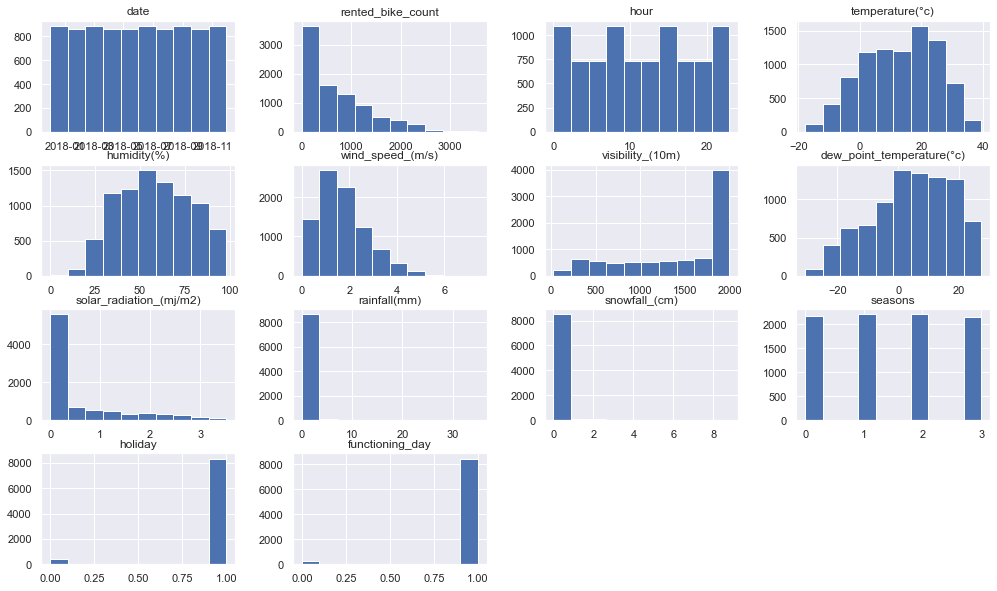

In [276]:
data.hist(figsize=(17, 10))
plt.show()

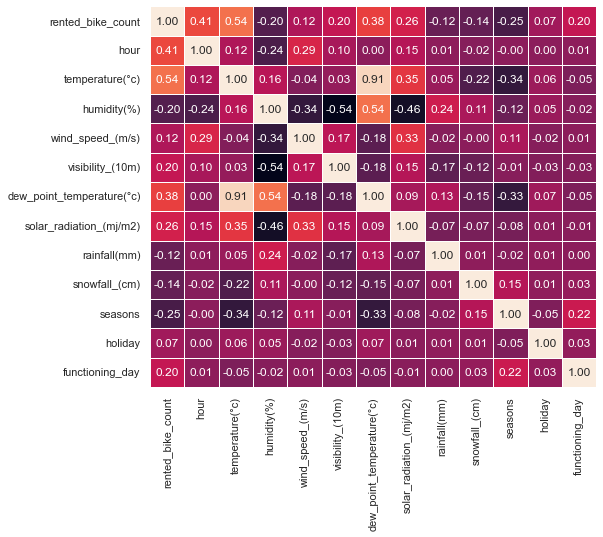

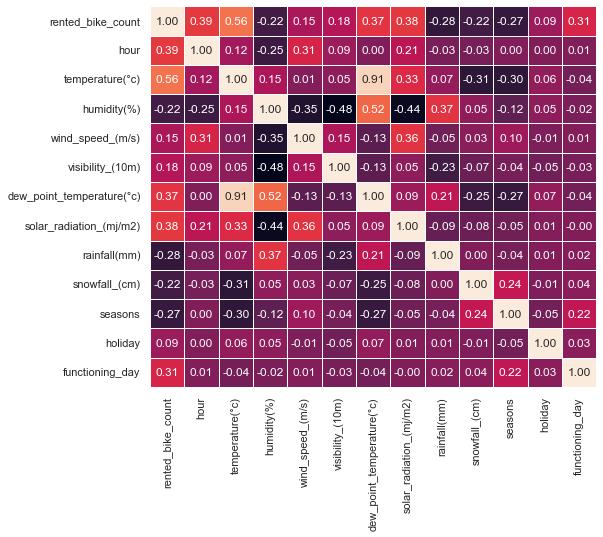

In [277]:
plt.figure(figsize=(8, 7))
sns.heatmap(data.corr(method='pearson'), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()
plt.figure(figsize=(8, 7))
sns.heatmap(data.corr(method='spearman'), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

Сильная корелляция есть только между температурой воздуха и температурой точки росы. Последнюю можно удалить.

In [278]:
data.drop(columns='dew_point_temperature(°c)', inplace=True)

Переместим дату в индекс датасета.

In [279]:
data.index = data.date.values
data.drop(columns="date", inplace=True)

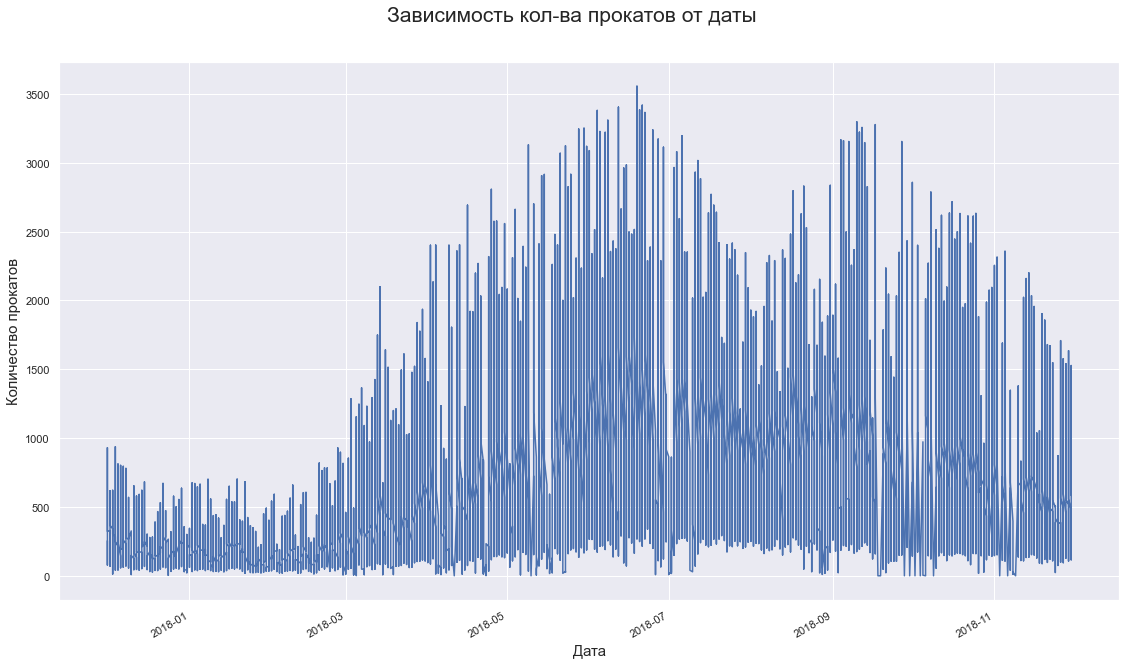

In [280]:
data['rented_bike_count'].plot(figsize=(19, 11))
plt.suptitle('Зависимость кол-ва прокатов от даты', fontsize=21, y=0.95)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Количество прокатов', fontsize=15)
plt.show()

В первые месяцы спрос был относительно невелик (вероятно, это связано с запуском прокатного бизнеса), далее наблюдается 2 пика в середине июня и в первой половине сентября.

Проверим датасет на выбросы.

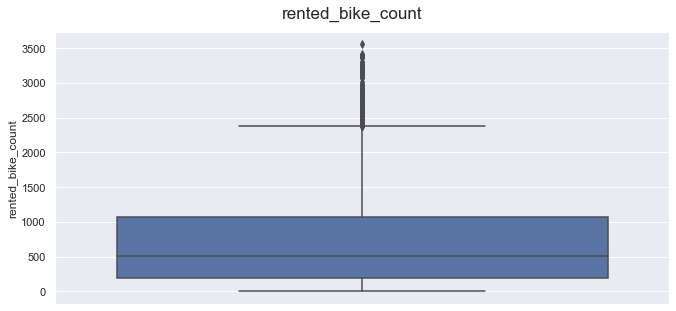

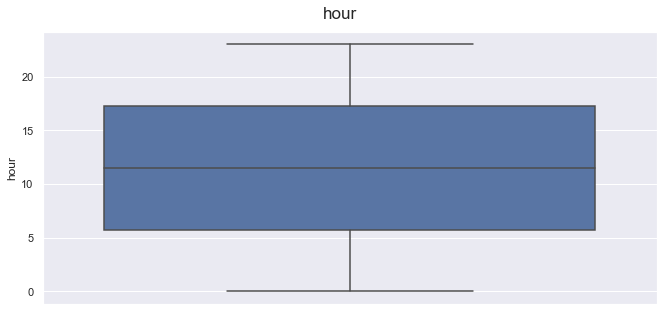

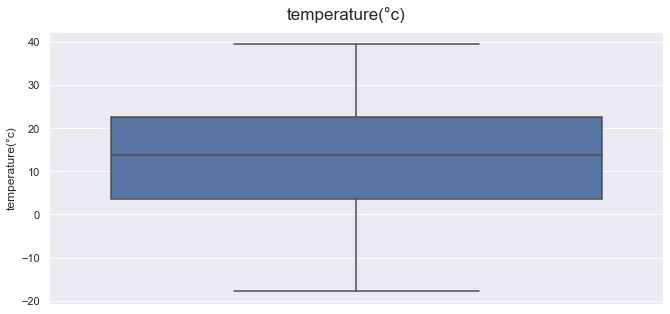

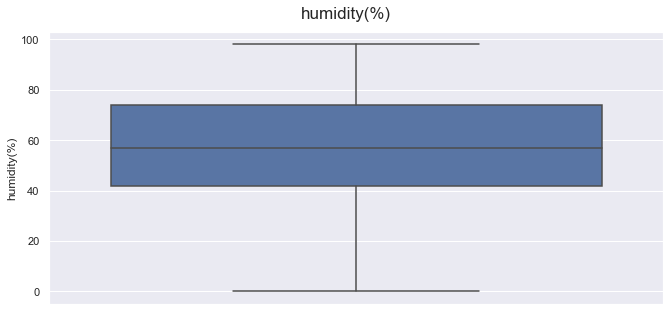

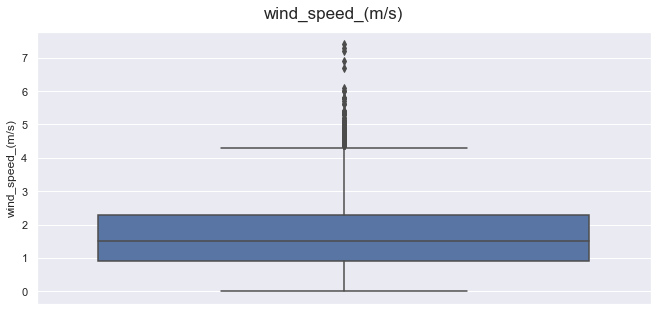

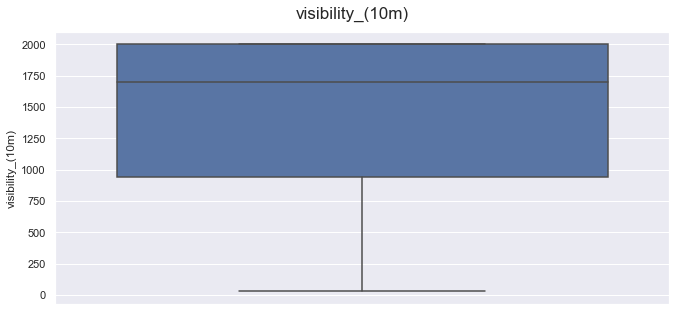

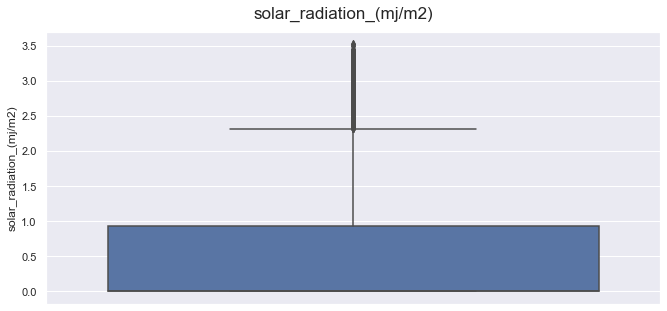

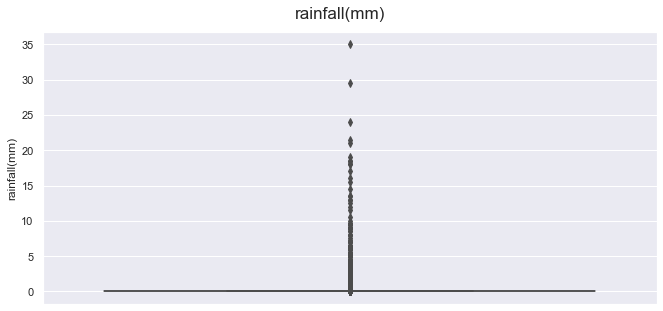

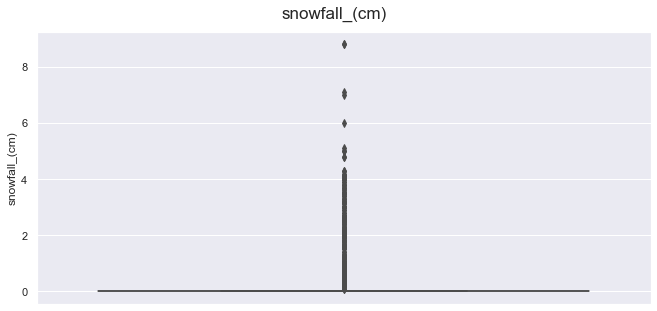

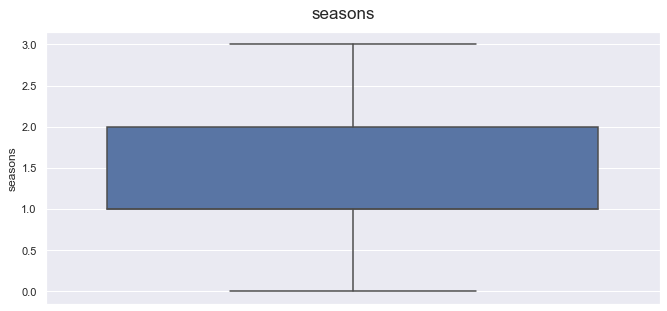

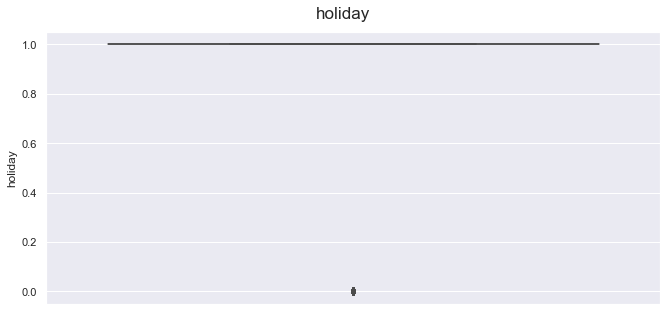

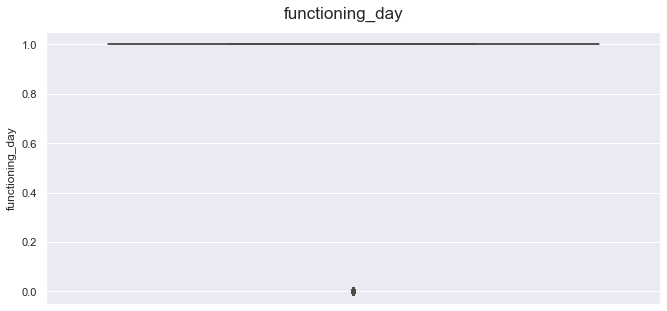

In [281]:
for column in data.columns:
    sns.boxplot(y=data[column])
    sns.set(rc={'figure.figsize':(11, 5)})
    plt.suptitle(column, fontsize=17, y=0.95)
    plt.show()

Можно удалить наблюдения с превышением верхней границы ящика на 3х межквартильных интервала. Для признака <b>'wind_speed_(m/s)'</b> это значение 6.5 м/с. Для признаков <b>'rainfall(mm)' и 'snowfall_(cm)'</b> это значение равно 0, однако удалять все превышающие значения неправильно, т.к. наличие дождливой или снежной погоды не является аномалией. В данном случае можно удалить сильно выбивающиеся значения согласно диаграммам размаха (rainfall(mm) более 20 мм и snowfall_(cm) более 4.5 см). Признаки <b>'holiday' и 'functioning_day'</b> являются категориальными, поэтому меньший класс выглядит как выброс, очистка не требуется.

In [282]:
data['wind_speed_(m/s)'].describe()['75%'] + 3*(data['wind_speed_(m/s)'].describe()['75%'] - data['wind_speed_(m/s)'].describe()['25%'])

6.499999999999999

In [283]:
data['rainfall(mm)'].describe()['75%'] + 3*(data['rainfall(mm)'].describe()['75%'] - data['rainfall(mm)'].describe()['25%'])

0.0

In [284]:
data['snowfall_(cm)'].describe()['75%'] + 3*(data['snowfall_(cm)'].describe()['75%'] - data['snowfall_(cm)'].describe()['25%'])

0.0

In [285]:
data = data[(data['wind_speed_(m/s)'] < 6.5) & (data['rainfall(mm)'] <= 20) & (data['snowfall_(cm)'] <= 4.5)]
print("В датасете осталось {:.2f} наблюдений ({:.1%} от первоначального количества)".format(data.shape[0], data.shape[0]/8760))

В датасете осталось 8740.00 наблюдений (99.8% от первоначального количества)


В качестве дополнительных признаков можно добавить год, месяц и день.

In [286]:
data['year'] = pd.DatetimeIndex(data.index).year
data['month'] = pd.DatetimeIndex(data.index).month
data['day'] = pd.DatetimeIndex(data.index).day

data.head()

,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,year,month,day
2017-12-01,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,3,1,1,2017,12,1
2017-12-01,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,3,1,1,2017,12,1
2017-12-01,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,3,1,1,2017,12,1
2017-12-01,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,3,1,1,2017,12,1
2017-12-01,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,3,1,1,2017,12,1


Посмотрим на качество двух базовых моделей: со средним и медианным значениями.

In [287]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

print("RMSE базовой модели со средним значением составляет {:.2f}".format(rmse(data.rented_bike_count, data.rented_bike_count.mean())), end='\n\n')
print("RMSE базовой модели с медианным значением составляет {:.2f}".format(rmse(data.rented_bike_count, data.rented_bike_count.median())), end='\n\n')

RMSE базовой модели со средним значением составляет 645.04

RMSE базовой модели с медианным значением составляет 674.93



Разбиваем датасет на обучающую и тестовую выборки

In [288]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='rented_bike_count'), data.rented_bike_count, test_size=0.2, random_state=800)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6992, 14), (1748, 14), (6992,), (1748,))

## Who's the mightiest of them all?

Проверим качество четырех моделей градиентного бустинга (GradientBoostingRegressor, XGBRegressor, LGBMRegressor, CatBoostRegressor) с гиперпараметрами, заданными по умолчанию.

In [289]:
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()
cbr = CatBoostRegressor(verbose=0)

gbr.fit(x_train, y_train)
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train)
cbr.fit(x_train, y_train)

print("RMSE у модели GradientBoostingRegressor составляет {:.2f}".format(mean_squared_error(y_test, gbr.predict(x_test), squared=False)), end='\n\n')
print("RMSE у модели XGBRegressor составляет {:.2f}".format(mean_squared_error(y_test, xgb.predict(x_test), squared=False)), end='\n\n')
print("RMSE у модели LGBMRegressor составляет {:.2f}".format(mean_squared_error(y_test, lgbm.predict(x_test), squared=False)), end='\n\n')
print("RMSE у модели CatBoostRegressor составляет {:.2f}".format(mean_squared_error(y_test, cbr.predict(x_test), squared=False)))

C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE у модели GradientBoostingRegressor составляет 260.72

RMSE у модели XGBRegressor составляет 221.54

RMSE у модели LGBMRegressor составляет 217.21

RMSE у модели CatBoostRegressor составляет 216.06


C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Лучшее качество с настройками по умолчанию показывает модель CatBoostRegressor со значением RMSE порядка 216.

Проведем настройку основных гиперпараметров рассматриваемых моделей.

In [295]:
folds = KFold(n_splits=5, shuffle=True, random_state=800)

gbr_param = {'learning_rate': [0.01, 0.1],
            'n_estimators': [200, 500],
            'subsample': [0.5, 0.7],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 3],
            'max_depth': [5, 10],
            'max_features': [0.5, 0.7]
            }

gbr_model = GradientBoostingRegressor(random_state=800)

gbr_model_grid = GridSearchCV(estimator=gbr_model, 
                            param_grid=gbr_param,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,
                            cv=folds,
                            verbose=1,
                            return_train_score=True)

gbr_model_grid.fit(x_train, y_train)

################################################################################################################################

xgb_param = {'eta': [0.01, 0.1],
            'n_estimators': [200, 500],
            'max_depth': [5, 10],
            'subsample': [0.5, 0.7],
            'min_child_weight': [2, 5],
            'colsample_bytree': [0.5, 0.7]
            }

xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', seed=800)

xgb_model_grid = GridSearchCV(estimator=xgb_model, 
                            param_grid=xgb_param,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,
                            cv=folds,
                            verbose=1,
                            return_train_score=True)

xgb_model_grid.fit(x_train, y_train)

################################################################################################################################

lgbm_param ={'n_estimators': [200, 500],
            'max_depth': [5, 10],
            'min_data_in_leaf': [1, 3],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.5, 0.7],
            'colsample_bytree': [0.5, 0.7]
            }

lgbm_model = LGBMRegressor(objective='mse', eval_metric='rmse', random_state=800)

lgbm_model_grid = GridSearchCV(estimator=lgbm_model,
                                param_grid=lgbm_param,
                                scoring='neg_root_mean_squared_error',
                                n_jobs=-1,
                                cv=folds,
                                verbose=1,
                                return_train_score=True)

lgbm_model_grid.fit(x_train, y_train)

################################################################################################################################

cbr_param = {'iterations': [200, 500],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.5, 0.7],
            'rsm': [0.5, 0.7],
            'depth': [5, 10],
            'min_data_in_leaf': [1, 3]
            }

cbr_model = CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE', random_seed=800, verbose=0)

cbr_model_grid = GridSearchCV(estimator=cbr_model,
                                param_grid=cbr_param,
                                scoring='neg_root_mean_squared_error',
                                n_jobs=-1,
                                cv=folds,
                                verbose=1,
                                return_train_score=True)

cbr_model_grid.fit(x_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits


C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=800, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000201DEF759F0>,
             n_jobs=-1,
             param_grid={'depth': [5, 10], 'iterations': [200, 500],
                         'learning_rate': [0.01, 0.1],
                         'min_data_in_leaf': [1, 3], 'rsm': [0.5, 0.7],
                         'subsample': [0.5, 0.7]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

Определим лучшую по качеству модель на тестовой выборке.

In [296]:
gbr_best_model = gbr_model_grid.best_estimator_
xgb_best_model = xgb_model_grid.best_estimator_
lgbm_best_model = lgbm_model_grid.best_estimator_
cbr_best_model = cbr_model_grid.best_estimator_

gbr_best_model.fit(x_train, y_train)
xgb_best_model.fit(x_train, y_train)
lgbm_best_model.fit(x_train, y_train)
cbr_best_model.fit(x_train, y_train)

print("RMSE у лучшей модели GradientBoostingRegressor составляет {:.2f}".format(mean_squared_error(y_test, gbr_best_model.predict(x_test), squared=False)), end='\n\n')
print("RMSE у лучшей модели XGBRegressor составляет {:.2f}".format(mean_squared_error(y_test, xgb_best_model.predict(x_test), squared=False)), end='\n\n')
print("RMSE у лучшей модели LGBMRegressor составляет {:.2f}".format(mean_squared_error(y_test, lgbm_best_model.predict(x_test), squared=False)), end='\n\n')
print("RMSE у лучшей модели CatBoostRegressor составляет {:.2f}".format(mean_squared_error(y_test, cbr_best_model.predict(x_test), squared=False)))

C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE у лучшей модели GradientBoostingRegressor составляет 211.21

RMSE у лучшей модели XGBRegressor составляет 220.00

RMSE у лучшей модели LGBMRegressor составляет 212.74

RMSE у лучшей модели CatBoostRegressor составляет 210.13


C:\Users\AVProkopenko\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


### <font color='Aquamarine'>Лучшей моделью осталась CatBoostRegressor, при этом ее качество после настройки основных гиперпараметров улучшилось с 216.1 до 210.1